# 모델2 : 맥동성

## 모델구성
- 레거시모델과 가장 유사하게 모델 구성
- 데이터 표준화

## 결과
- 기존모델의 성능
  - Epoch : 10 , lr : 0.001
  - Train Loss : 1.014
  - Test Accuracy = 0.976
  - Test Precision = 0.926
  - Test Recall = 0.789
  - Test F1 = 0.852
- 모델링 결과
  - Test Loss : 0.074 / Accuracy  : 0.978
- 평가
  - 200에포크 이후로 성능이 오르지 않아 440에포크에 조기종료 되었음
  - 훈련점수와 검증점수의 차이가 없어 과소적합이 의심됨
  - 성능을 올리기 위하여 복잡도를 증가시키는 방향의 개선 필요

In [2]:
# Tensorflow Check
import tensorflow as tf
from tensorflow.python.client import device_lib
import sys
print(f'Python     : {sys.version.split("|")[0]}')
print(f'Tensorflow : {tf.__version__}')
print(f'TF GPU     : {"True" if device_lib.list_local_devices()[1] else "False"}')

Python     : 3.10.11 
Tensorflow : 2.10.1
TF GPU     : True


In [3]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow import keras
from IPython.display import clear_output
import json

# 각종 변수 선언
csv_path = 'D:/coding/aib/GPTeachersDay/TeamProject1/leeyeonjun/Data/binary_classification_data.csv'
EPOCHS = 1000
MB_SIZE = 1024

In [10]:
# 필요한 함수 / 메소드 정의
class CustomCallback(keras.callbacks.Callback):
    """
    사용자 정의 콜백함수
    """
    def on_train_begin(self, logs=None):
        print("Starting training")

    def on_train_end(self, logs=None):
        print("End training")
        # clear_output(wait=True)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:print()
        if epoch % 10 == 0:
            print(f'{epoch} / ', end='')

def load_data(csv_path, TRAIN_RATIO=0.8):
    global X, y, X_train, X_test, y_train, y_test, df
    
    # 데이터셋 로드
    df = pd.read_csv(csv_path)
    
    # 학습 데이터 분리
    X = df.drop('target_class', axis=1)
    y = df['target_class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_RATIO, random_state = 83)
    
    # 표준화
    scaler = StandardScaler() 
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)

def get_model(shape, node_n=8, dout=0.0001):
    inputs  = keras.Input(shape=shape)
    
    dense1  = keras.layers.Dense(node_n)(inputs)
    norm1   = keras.layers.BatchNormalization()(dense1)
    relu1   = keras.layers.Activation('relu')(norm1)
    dout1   = keras.layers.Dropout(dout)(relu1)
    
    outputs = keras.layers.Dense(1, activation='sigmoid')(dout1)
    model   = keras.Model(inputs, outputs, name='Star_Model')
    
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
        )
    return model

In [12]:
load_data(csv_path)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.describe()

(14318, 8) (3580, 8) (14318,) (3580,)


,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve
count,14318.000000,14318.000000,14318.000000,14318.000000,14318.000000,14318.000000,14318.000000,14318.000000
mean,110.979922,46.524674,0.477455,1.748246,12.444476,26.217401,8.333270,105.312684
std,25.526123,6.782110,1.052675,6.072202,29.200648,19.425697,4.491693,106.165624
min,5.812500,24.772042,-1.876011,-1.755332,0.213211,7.370432,-2.812353,-1.976976
25%,100.710938,42.362011,0.028368,-0.186510,1.917224,14.416392,5.797204,35.364865
50%,114.914062,46.954915,0.223197,0.197768,2.788880,18.415923,8.460192,83.517364
75%,127.015625,51.001216,0.476759,0.937653,5.414716,28.217723,10.721939,140.055368
max,192.617188,91.206475,8.069522,68.101622,211.948997,110.642211,34.539844,1191.000837


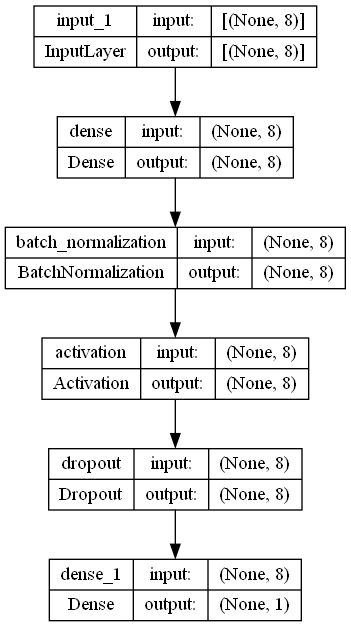

In [13]:
model = get_model(len(X_train.columns))
keras.utils.plot_model(model, show_shapes=True, to_file='model1_model.png')

In [14]:
# 얼리스타핑
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy'
                                        , min_delta=0.000001
                                        , patience=EPOCHS//5)

# 모델 저장
checkpoint_path = 'model1.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
                                        checkpoint_path
                                        , monitor='val_accuracy'
                                        , verbose=0
                                        , save_best_only=True
                                        , save_weights_only=True)

# 모델 학습
history = model.fit(X_train, y_train
                , batch_size=MB_SIZE
                , validation_split = 0.2
                , verbose=0
                , epochs=EPOCHS
                , callbacks=[earlystop, checkpoint, CustomCallback()]
                )

# 가장 성능이 좋았던 모델을 가져와 평가
model.load_weights(checkpoint_path)
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss : {loss:.3f} / Accuracy  : {accuracy:.3f}')

Starting training

0 / 10 / 20 / 30 / 40 / 50 / 60 / 70 / 80 / 90 / 
100 / 110 / 120 / 130 / 140 / 150 / 160 / 170 / 180 / 190 / 
200 / 210 / 220 / 230 / 240 / 250 / 260 / 270 / 280 / 290 / 
300 / 310 / 320 / 330 / 340 / 350 / 360 / 370 / 380 / 390 / 
400 / 410 / 420 / 430 / 440 / End training
112/112 [==============================] - 1s 5ms/step - loss: 0.0740 - accuracy: 0.9777
Test Loss : 0.074 / Accuracy  : 0.978


In [15]:
import json
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist = hist.set_index('epoch')
hist.to_json('model1.json')

with open('model1.json') as json_file:
    json_file = json.loads(json_file.read())
model1_hist = pd.DataFrame(json_file)
model1_hist

,loss,accuracy,val_loss,val_accuracy
0,1.122609,0.091235,4.499202,0.094623
1,1.070438,0.108346,2.754606,0.094623
2,1.020593,0.141261,1.891845,0.094623
3,0.970758,0.184390,1.370128,0.094623
4,0.923996,0.233281,1.029709,0.100559
...,...,...,...,...
438,0.068947,0.980007,0.061250,0.980447
439,0.069530,0.979221,0.061755,0.981145
440,0.069168,0.979745,0.059365,0.980447
441,0.069141,0.979920,0.059574,0.980447


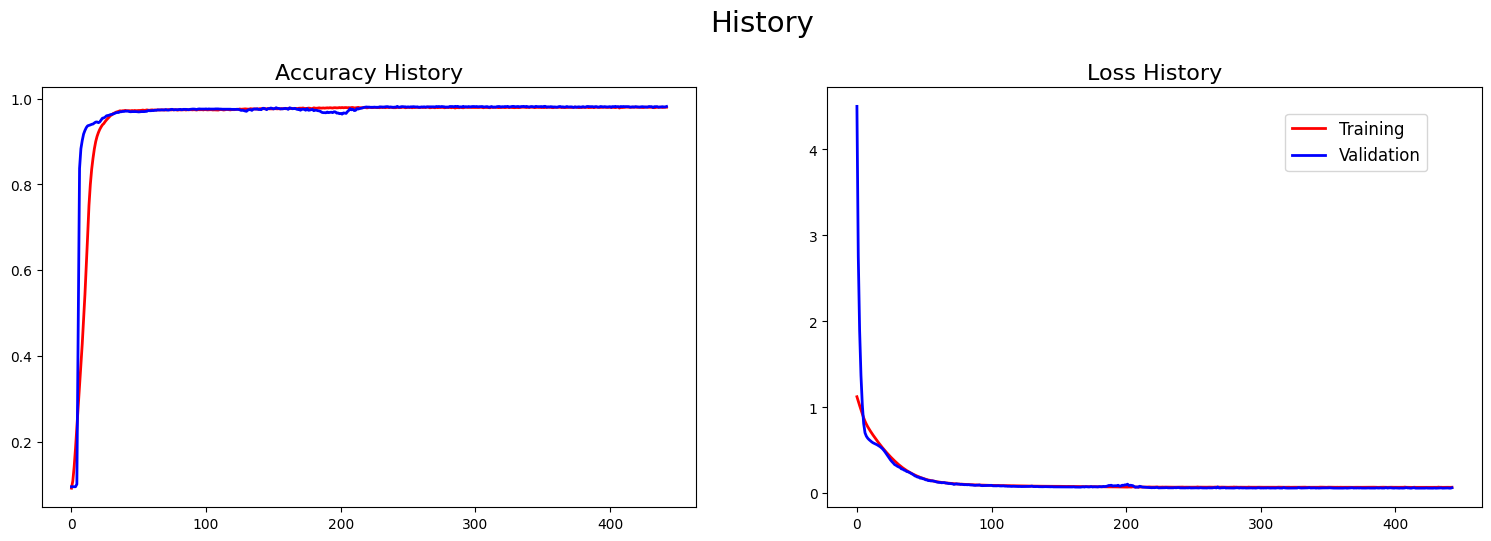

In [16]:
fig = plt.figure(figsize=(16, 6))
fig.suptitle('History', fontsize = 21)

# Accuracy Plot
ax = plt.subplot(1, 2, 1)
plt.title(f'Accuracy History', fontsize = 16, y = 1)
plt.plot(history.history["accuracy"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_accuracy"], color='b', linewidth=2, label="Validation")

# Loss Plot
ax = plt.subplot(1, 2, 2)
plt.title(f'Loss History', fontsize = 16, y = 1)
plt.plot(history.history["loss"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_loss"], color='b', linewidth=2, label="Validation")

plt.legend(fontsize=12, loc=(0.7, 0.8))
plt.subplots_adjust(right=0.95, left=0.05, top=0.85, bottom=0.15, wspace=0.2, hspace=0.2)
plt.show()

fig.savefig('model1_history.png', dpi=80, bbox_inches='tight')